# Back-test : Estrategia Maximos y minimos historicos

En este backtest voy a realizar una estrategia basada en los los precios maximos y minimos que vamos encontrando en las ultimas 50 rondas. En caso de que el Low sea igual al valor minimo de las ultimas 50 rondas, compro la accion. En cuanto al maximo, si estoy comprado y la acción alcanza el maximo de las ultimas 50 ruedas, vendo la misma.

### Carga de las Librerias

* Pandas : para mostrar los datos en un dataframe y poder analizarlo.
* pandas_datareader : para importar los datos de "Yahoo Finance"
* datetime : para poder trabajar con fechas
* numpy :nos va a ser util para trabajar con datos NaN
* itertools : para realizar todas las iteraciones de los cruces

In [562]:
from pandas_datareader import data
import pandas as pd
import datetime as dt
from datetime import date
import numpy as np

* Creamos la funcion ajustar_columnas , la cual va a recibir los datos descargados anteriormente.

* Esta funcion se va a encargar de ajustar las columnas ,usando el coeficiente que surge entre los datos de cierre ajustados / datos de cierre.

* Una vez ajustadas todas las columnas, borra las que quedaron sin ajustar

* Por ultimo crea una columna "Dif_Close" con la difenrencia entre el cierre de ayer y hoy. El producto acumulado de esta diferencia lo voy guardando en la columna "Buy_and_Hold".

In [564]:
def ajustar_columnas(dataframe):
    dataframe['coef']=dataframe['Adj Close'] / dataframe['Close']
    dataframe['High']=dataframe['High']*dataframe.coef
    dataframe['Low']=dataframe['Low']*dataframe.coef
    dataframe['Open']=dataframe['Open']*dataframe.coef
    dataframe['Close']=dataframe['Adj Close']
    dataframe=dataframe.drop(['coef','Adj Close'],axis=1) #Borro las columnas que ya no necesito
    dataframe['Dif_Close']=dataframe.Close.pct_change()
    
    return dataframe

## Estrategia Maximos y minimos historicos

La funcion "agrega_min_max_hitoricos" recibe el dataframe y en principio hace un doble bucle, en el primero irá marcando los 10 minimos valores de los ultmimas 50 ruedas, y en el segundo hará lo mismo pero marcando los maximos.

In [565]:
def agrega_min_max_hitoricos(dataframe):    
    
    minimos_maximos=['minimos_historicos','maximos_historicos']
    
    for min_max in minimos_maximos:
        if min_max == 'minimos_historicos':            
            minimos=list(dataframe.Low.iloc[-50:].sort_values(ascending=False).iloc[-10:])
            indice=list(dataframe.Low.iloc[-50:].sort_values(ascending=False).iloc[-10:].index)   
            dataframe.loc[indice,'minimos_historicos'] =minimos 

        if min_max == 'maximos_historicos':            
            maximos=list(dataframe.High.iloc[-50:].sort_values(ascending=True).iloc[-10:])
            indice=list(dataframe.High.iloc[-50:].sort_values(ascending=True).iloc[-10:].index)  
            dataframe.loc[indice,'maximos_historicos'] =maximos    

    return dataframe


El objetivo de la estrategia se basa en comprar cuando el valor minimo del dia se encuentre dentro de los 10 minimos de las ultimas 50 ruedas. La señal de venta se dara cuando el maximo valor del dia atraviese uno de los 10 maximos valores de las ultimas 50 ruedas

In [566]:
def trade_valores_historicos(dataframe):  
     
    dataframe['Senal']=np.where(dataframe.Low <= dataframe['minimos_historicos'] ,1,np.where((dataframe.High >= dataframe['maximos_historicos']) ,-1,np.NaN))
    dataframe['Senal']=dataframe.Senal.ffill()
    dataframe['Posicion'] = dataframe.Senal.shift(1)    # mi posicion se activará al otro dia de la señal.
    dataframe['Trade'] = np.where( dataframe.Posicion==1 & (dataframe.Posicion!= dataframe.Posicion.shift())  ,1 ,np.where( (dataframe.Posicion!= dataframe.Posicion.shift()) & dataframe.Posicion.shift()==1  ,-1 ,0)) # Cuando mi posicion me da compra y no estoy comprado, entro en la posicion con Trade=1. Cuando estoy comprado y la posicion da venta, el trade queda en -1 . Cuando no ocurre ninguno de los dos casos, el trade es cero ( esto se puede dar o porque sigo comprado , o porque todavia no entré en ninguna posicion)
    return dataframe

## Obtenemos los datos de cada estrategia

* Vamos a crear la funcion datos_estrategia que va a recibir el dataframe.


In [576]:
def datos_estrategia(dataframe):     
    
    dataframe['Retornos'] = np.where(( (dataframe.Trade!=0 ) ),dataframe.Dif_Close -0.0085 ,
    np.where(dataframe.Posicion==1,dataframe.Dif_Close,0) )    
    dataframe['capital_estrategia'] = (dataframe.Retornos + 1).cumprod() * 100 
    
    return dataframe

In [587]:
def resultado_estrategia(dataframe):
  
    dataframe_estrategia=dataframe # Creamos una copia del dataframe ya que vamos a hacer modificaciones, y no queremos perder el original.
    resultado={} #creamos un diccionario para ir guardando los resultados
    resultado['Beneficio Bruto'] = round(dataframe_estrategia.iloc[-1]['capital_estrategia']-100,2) 
    dataframe_estrategia=dataframe_estrategia[dataframe.Trade !=0] # Filtramos el dataframe para obtener solo las lineas donde se operó.     
    resultado['trades']=dataframe_estrategia['Trade'].count()  # Cantidad de trades

    dataframe_estrategia=dataframe_estrategia[['Posicion','capital_estrategia']]
    dataframe_estrategia['resultado_trade']=np.where((dataframe_estrategia.Posicion==-1)&(dataframe_estrategia.Posicion.shift()==1),        dataframe_estrategia['capital_estrategia']-dataframe_estrategia['capital_estrategia'].shift(),0 ) # Restamos el capital que obtuvimos luego de una venta ,con el capital anterior en el momento de compra. Este calculo si es positivo ,nos indica que el Trade fue ganador, de lo contrario perdimos.
    resultado['trades_ganadores']=dataframe_estrategia.resultado_trade[dataframe_estrategia.resultado_trade >= 0].count()
    resultado['suma_trades_ganadores']=round(dataframe_estrategia.resultado_trade[dataframe_estrategia.resultado_trade >= 0].sum(),2)
    resultado['trades_perdedores']=dataframe_estrategia.resultado_trade[dataframe_estrategia.resultado_trade < 0].count()
    resultado['suma_trades_perdedores']=abs(round(dataframe_estrategia.resultado_trade[dataframe_estrategia.resultado_trade < 0].sum(),2))

    if resultado['trades_ganadores'] ==0:
        resultado['Ratio Acierto'] = 0
        resultado['Profit Factor'] = 0

    elif resultado['trades_perdedores']==0:
        resultado['Ratio Acierto'] = 100
        resultado['Profit Factor'] = 100

    else:
        resultado['Ratio Acierto'] = round(100 * resultado['trades_ganadores'] / resultado['trades'], 2)
        resultado['Profit Factor'] = round( resultado['suma_trades_ganadores'] / resultado['suma_trades_perdedores'], 2)
    # cuando  trades_ganadores o trades_perdedores sea igual a cero ,completamos manualmente el Ratio Acierto y Profit Factor, ya que de lo contrario nos daria error por division por cero.  
    resultado['capital_estrategia']=round(dataframe['capital_estrategia'].iloc[-1],2)
    
    return resultado

# Corremos la estrategia


Primero vamos a descargar 2 datasets para la misma accion. Uno con datos anteriores al momento desde el cual queremos comprobar la estrategia y otro con los datos desde la fecha de inicio de la estrategia hasta la actual.

El motivo de descargar los datos en 2 tramos ,es que si corremos la estrategia solo con datos actuales, en el primer bucle debe detectar minimos y maximos, y como no encuentra datos anteriores ,los primeros datos que encuentre los pondrá como minimos y maximos , y esto nos daria errores.

Por este motivo  , vamos a ir agregando de a uno los datos del datos_futuros al datos_antiguos. De esta manera, en cada bucle, vamos a tener todos los datos viejos mas el nuevo dato. Por lo tanto ,cada iteracion agregará una fecha nueva al dataframe datos_antiguos.



In [584]:

accion='GGAL'
start_date = dt.datetime(2015, 1, 1)
end_date = dt.datetime(2020,12 , 31)
hoy = dt.datetime(2021,5, 1)

datos_antiguos=data.DataReader(accion,'yahoo',start_date,end_date) # datos antiguos sobre los cuales se iran agregando los nuevos datos 
datos_futuros=data.DataReader(accion,'yahoo',end_date,hoy) # datos sobre los cual hago el bucle, y los voy agregando a los viejos
datos_antiguos=ajustar_columnas(datos_antiguos)
datos_futuros=ajustar_columnas(datos_futuros)
datos_antiguos['minimos_historicos']=np.NaN # creo una columna para cada dataframe con valores NaN
datos_antiguos['maximos_historicos']=np.NaN
datos_futuros['minimos_historicos']=np.NaN
datos_futuros['maximos_historicos']=np.NaN

for dia_nuevo in range(len(datos_futuros)):    #corro un nuevo bucle por cada dia del nuevo dataframe
    indice=datos_futuros.index[dia_nuevo] #obtengo el indice de los datos nuevos, para ir agregandolo a los viejos
    if dia_nuevo==0:
        primer_indice=indice

    #datos_nuevos_bucle=list(datos_futuros[['High', 'Low', 'Open', 'Close', 'Volume','Adj Close','minimos_historicos','maximos_historicos']].loc[indice])
    datos_nuevos_bucle=datos_futuros.loc[indice]
    datos_antiguos.loc[indice]=datos_nuevos_bucle # agrega el nuevo dia al dataframe    
    #datos_a_correr=datos_antiguos.loc[primer_indice:]  
    # # Filtro los datos desde la primer fecha de la estrategia hasta el final. En la primera iteracion 
    datos_con_minimos_maximos=agrega_min_max_hitoricos(datos_antiguos)
    datos_con_minimos_maximos=datos_con_minimos_maximos.loc[primer_indice:]
    datos_final=trade_valores_historicos(datos_con_minimos_maximos)      

estrategia=datos_estrategia(datos_final)

datos_futuros['Buy_and_Hold'] = (datos_futuros.Dif_Close + 1).cumprod() * 100 # hacemos estos pasos para cargar los datos de la estrategia Buy and Hold en el dataframe llamado estrategia
datos_futuros.loc[datos_futuros.index[0],'Buy_and_Hold']=100
Buy_and_Hold_indice=list(datos_futuros.index)  
Buy_and_Hold_valores=list(datos_futuros.Buy_and_Hold)
estrategia['Buy_and_Hold']=np.NaN
estrategia.loc[Buy_and_Hold_indice,'Buy_and_Hold'] =Buy_and_Hold_valores 

resultados = resultado_estrategia(estrategia)        


e documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Senal']=dataframe.Senal.ffill()
<ipython-input-566-01c9ab704fa8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Posicion'] = dataframe.Senal.shift(1)    # mi posicion se activará al otro dia de la señal.
<ipython-input-566-01c9ab704fa8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Trade'] = np.where( dataframe.Posicion==1 & (dataframe.Posicion!= dataf

## Visualizamos los resultados

In [585]:
resultados

{'Beneficio Bruto': 3.84,
 'trades': 6,
 'trades_ganadores': 5,
 'suma_trades_ganadores': 7.49,
 'trades_perdedores': 1,
 'suma_trades_perdedores': 1.18,
 'Ratio Acierto': 83.33,
 'Profit Factor': 6.35,
 'capital_estrategia': 103.84}

In [586]:
estrategia

,High,Low,Open,Close,Volume,Dif_Close,minimos_historicos,maximos_historicos,Senal,Posicion,Trade,Retornos,capital_estrategia,Buy_and_Hold
Date,,,,,,,,,,,,,,
2020-12-31,8.878040,8.441578,8.808603,8.669728,696800.0,NaN,NaN,8.878040,-1.0,NaN,0,0.000000,100.000000,100.000000
2021-01-04,8.679648,8.134070,8.679648,8.213427,1137500.0,-0.052632,NaN,8.679648,-1.0,-1.0,0,0.000000,100.000000,94.736840
2021-01-05,8.332462,8.034875,8.104312,8.124150,469000.0,-0.010870,NaN,NaN,-1.0,-1.0,0,0.000000,100.000000,93.707092
2021-01-06,8.471336,8.104311,8.233266,8.243186,593800.0,0.014652,NaN,8.471336,-1.0,-1.0,0,0.000000,100.000000,95.080096
2021-01-07,8.471337,8.044794,8.382060,8.253105,828000.0,0.001203,NaN,8.471337,-1.0,-1.0,0,0.000000,100.000000,95.194508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,7.380181,7.142110,7.142110,7.350422,680500.0,0.029167,NaN,NaN,1.0,1.0,0,0.029167,101.733446,84.782610
2021-04-27,7.747206,7.340503,7.340503,7.657929,910300.0,0.041835,NaN,NaN,1.0,1.0,0,0.041835,105.989501,88.329521
2021-04-28,8.064633,7.618251,7.657930,7.727367,887800.0,0.009067,NaN,8.064633,-1.0,1.0,0,0.009067,106.950550,89.130440


Cargamos la libreria de graficos y definimos el tamaño de los gráficos para que se ajusten bien al notebook

In [559]:
%matplotlib inline   
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

Comparativa entre la estrategia Buy and Hold, y nuestro sistema

<AxesSubplot:xlabel='Date'>

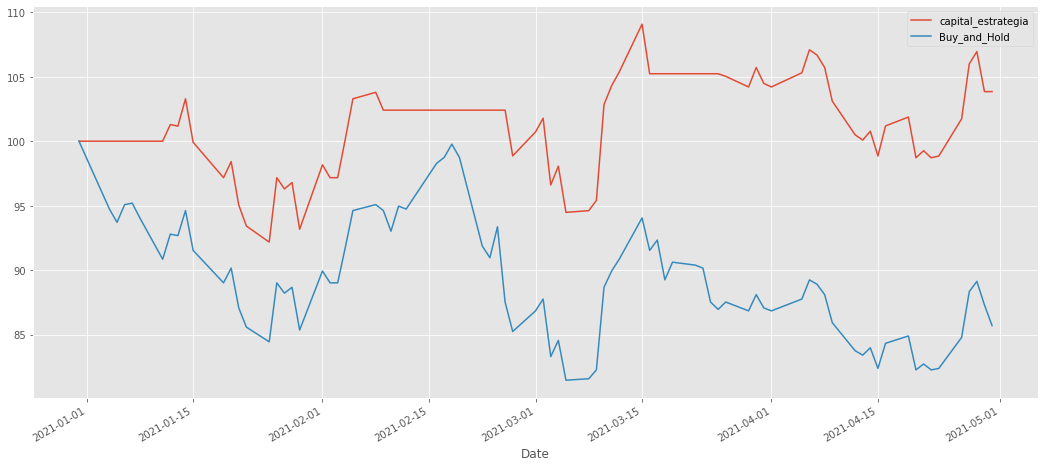

In [574]:
estrategia[['capital_estrategia','Buy_and_Hold']].plot()

Graficamos los minimos y maximos de nuestro sistema. Vemos que los minimos nos dan las entradas ,y los maximos las salidas.

<AxesSubplot:xlabel='Date'>

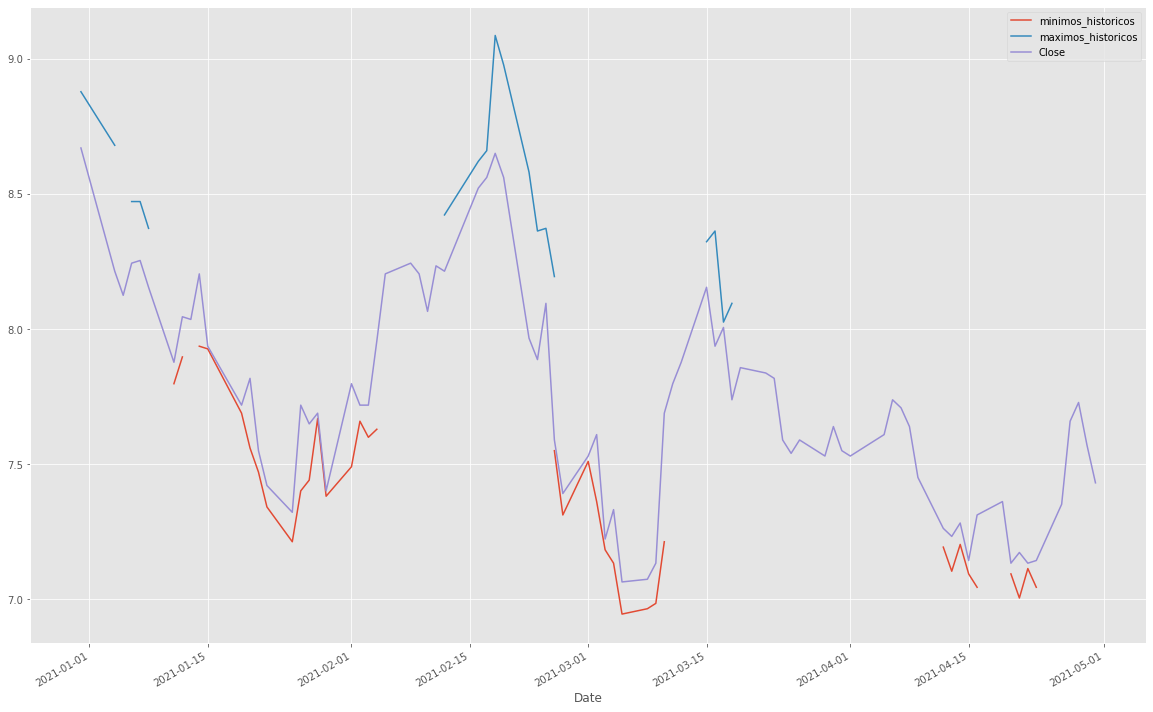

In [578]:
estrategia[['minimos_historicos','maximos_historicos','Close']].plot(figsize=(20,13))